<a href="https://colab.research.google.com/github/ZwwWayne/mmdetection/blob/update-colab/demo/MMDet_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()      

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  9% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  0% | 10% |


# MMDetection Cascade - RCNN  Defect Steel Surface


In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

/bin/bash: nvcc: command not found
gcc (Ubuntu 8.4.0-3ubuntu2) 8.4.0
Copyright (C) 2018 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

1.7.0 True
2.17.0
10.1
GCC 7.3


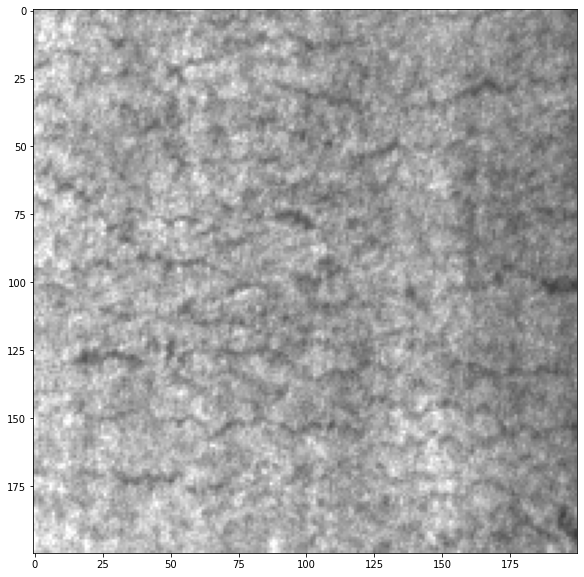

In [2]:
# Let's take a look at the dataset image
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('data/VOCdevkit/VOC2007/JPEGImages/crazing_1.jpg')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [3]:
# Check the label of a single image
!cat data/VOCdevkit/VOC2007/Annotations/crazing_1.xml


<annotation>
	<folder>cr</folder>
	<filename>crazing_1.jpg</filename>
	<source>
		<database>NEU-DET</database>
	</source>
	<size>
		<width>200</width>
		<height>200</height>
		<depth>1</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>crazing</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>2</xmin>
			<ymin>2</ymin>
			<xmax>193</xmax>
			<ymax>194</ymax>
		</bndbox>
	</object>
</annotation>


In [4]:
from mmcv import Config
cfg = Config.fromfile('configs/detectors/detectors_cascade_rcnn_r50_1x_voc0712.py')



In [5]:
from mmdet.apis import set_random_seed
# modify num classes of the model in box head
#cfg.model.roi_head.bbox_head.num_classes = 3
# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = 'checkpoints/cascade_rcnn_r50_fpn_1x_coco_20200316-3dc56deb.pth'
# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'
# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
#cfg.optimizer.lr = 0.03
#cfg.log_config.interval = 1
# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
# We can set the checkpoint saving interval to reduce the storage cost
# Set seed thus the results are more reproducible
# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')


Config:
model = dict(
    type='CascadeRCNN',
    backbone=dict(
        type='DetectoRS_ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50'),
        conv_cfg=dict(type='ConvAWS'),
        sac=dict(type='SAC', use_deform=True),
        stage_with_sac=(False, True, True, True),
        output_img=True),
    neck=dict(
        type='RFP',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5,
        rfp_steps=2,
        aspp_out_channels=64,
        aspp_dilations=(1, 3, 6, 1),
        rfp_backbone=dict(
            rfp_inplanes=256,
            type='DetectoRS_ResNet',
            depth=50,
            num_stages=4,
            out_indices=(0, 1, 2, 3),
            frozen_stages=1,
            norm_cfg=dict(type='BN', 

### Train a new detector

Finally, lets initialize the dataset and detector, then train a new detector!

In [6]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)



/home/maraden/mmdetection/tugasakhir/Detector RS/mmdet/core/anchor/builder.py:17: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  '``build_anchor_generator`` would be deprecated soon, please use '


In [7]:
# Create work_dir
import copy
import os.path as osp
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

2021-12-29 05:23:21,696 - mmdet - INFO - load checkpoint from checkpoints/cascade_rcnn_r50_fpn_1x_coco_20200316-3dc56deb.pth
2021-12-29 05:23:21,698 - mmdet - INFO - Use load_from_local loader
2021-12-29 05:23:26,220 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.0.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([7, 1024]).
size mismatch for roi_head.bbox_head.0.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([7]).
size mismatch for roi_head.bbox_head.1.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([7, 1024]).
size mismatch for roi_head.bbox_head.1.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([7]).
size mismatch for roi_head.bbox_head.2.fc

2021-12-29 05:23:26,225 - mmdet - INFO - Start running, host: maraden@maraden-System-Product-Name, work_dir: /home/maraden/mmdetection/tugasakhir/Detector RS/tutorial_exps
2021-12-29 05:23:26,226 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) NumClassCheckHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) StepLrUpdaterHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
 -------------------- 
after_tr

2021-12-29 05:38:19,000 - mmdet - INFO - Epoch [1][850/3774]	lr: 1.000e-03, eta: 12:57:52, time: 1.045, data_time: 0.003, memory: 4243, loss_rpn_cls: 0.0107, loss_rpn_bbox: 0.0182, s0.loss_cls: 0.1397, s0.acc: 95.2578, s0.loss_bbox: 0.0907, s1.loss_cls: 0.0762, s1.acc: 94.9883, s1.loss_bbox: 0.0967, s2.loss_cls: 0.0421, s2.acc: 94.1484, s2.loss_bbox: 0.0540, loss: 0.5283
2021-12-29 05:39:11,264 - mmdet - INFO - Epoch [1][900/3774]	lr: 1.000e-03, eta: 12:56:47, time: 1.045, data_time: 0.003, memory: 4243, loss_rpn_cls: 0.0160, loss_rpn_bbox: 0.0190, s0.loss_cls: 0.1469, s0.acc: 94.8711, s0.loss_bbox: 0.1006, s1.loss_cls: 0.0771, s1.acc: 94.6925, s1.loss_bbox: 0.1069, s2.loss_cls: 0.0411, s2.acc: 94.0796, s2.loss_bbox: 0.0572, loss: 0.5648
2021-12-29 05:40:03,449 - mmdet - INFO - Epoch [1][950/3774]	lr: 1.000e-03, eta: 12:55:40, time: 1.044, data_time: 0.003, memory: 4243, loss_rpn_cls: 0.0090, loss_rpn_bbox: 0.0130, s0.loss_cls: 0.1307, s0.acc: 94.8242, s0.loss_bbox: 0.1026, s1.loss_cls

2021-12-29 05:57:31,773 - mmdet - INFO - Epoch [1][1950/3774]	lr: 1.000e-03, eta: 12:37:40, time: 1.049, data_time: 0.003, memory: 4243, loss_rpn_cls: 0.0109, loss_rpn_bbox: 0.0148, s0.loss_cls: 0.1063, s0.acc: 95.8789, s0.loss_bbox: 0.0926, s1.loss_cls: 0.0581, s1.acc: 95.2813, s1.loss_bbox: 0.1098, s2.loss_cls: 0.0295, s2.acc: 95.1330, s2.loss_bbox: 0.0583, loss: 0.4803
2021-12-29 05:58:24,259 - mmdet - INFO - Epoch [1][2000/3774]	lr: 1.000e-03, eta: 12:36:49, time: 1.050, data_time: 0.003, memory: 4243, loss_rpn_cls: 0.0095, loss_rpn_bbox: 0.0112, s0.loss_cls: 0.1347, s0.acc: 94.4727, s0.loss_bbox: 0.1147, s1.loss_cls: 0.0668, s1.acc: 94.5719, s1.loss_bbox: 0.1158, s2.loss_cls: 0.0334, s2.acc: 94.6142, s2.loss_bbox: 0.0584, loss: 0.5445
2021-12-29 05:59:16,719 - mmdet - INFO - Epoch [1][2050/3774]	lr: 1.000e-03, eta: 12:35:56, time: 1.049, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0088, loss_rpn_bbox: 0.0092, s0.loss_cls: 0.1149, s0.acc: 95.3477, s0.loss_bbox: 0.0958, s1.loss_

2021-12-29 06:16:43,864 - mmdet - INFO - Epoch [1][3050/3774]	lr: 1.000e-03, eta: 12:18:01, time: 1.043, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0060, loss_rpn_bbox: 0.0174, s0.loss_cls: 0.0922, s0.acc: 96.2969, s0.loss_bbox: 0.0747, s1.loss_cls: 0.0488, s1.acc: 96.1575, s1.loss_bbox: 0.1040, s2.loss_cls: 0.0272, s2.acc: 95.6226, s2.loss_bbox: 0.0723, loss: 0.4425
2021-12-29 06:17:36,022 - mmdet - INFO - Epoch [1][3100/3774]	lr: 1.000e-03, eta: 12:17:05, time: 1.043, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0059, loss_rpn_bbox: 0.0112, s0.loss_cls: 0.0913, s0.acc: 96.2148, s0.loss_bbox: 0.0755, s1.loss_cls: 0.0481, s1.acc: 96.2287, s1.loss_bbox: 0.0928, s2.loss_cls: 0.0264, s2.acc: 95.6865, s2.loss_bbox: 0.0619, loss: 0.4131
2021-12-29 06:18:28,540 - mmdet - INFO - Epoch [1][3150/3774]	lr: 1.000e-03, eta: 12:16:14, time: 1.050, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0084, loss_rpn_bbox: 0.0107, s0.loss_cls: 0.1142, s0.acc: 95.3477, s0.loss_bbox: 0.1030, s1.loss_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 540/540, 3.1 task/s, elapsed: 171s, ETA:     0s
---------------iou_thr: 0.5---------------


2021-12-29 06:32:16,334 - mmdet - INFO - 
+-----------------+-----+------+--------+-------+
| class           | gts | dets | recall | ap    |
+-----------------+-----+------+--------+-------+
| crazing         | 244 | 2314 | 0.980  | 0.480 |
| inclusion       | 147 | 719  | 0.986  | 0.858 |
| patches         | 184 | 404  | 0.989  | 0.891 |
| pitted_surface  | 105 | 715  | 0.971  | 0.860 |
| rolled-in_scale | 148 | 1311 | 0.980  | 0.649 |
| scratches       | 135 | 278  | 0.985  | 0.900 |
+-----------------+-----+------+--------+-------+
| mAP             |     |      |        | 0.773 |
+-----------------+-----+------+--------+-------+
2021-12-29 06:32:16,378 - mmdet - INFO - Epoch(val) [1][540]	AP50: 0.7730, mAP: 0.7730
2021-12-29 06:33:10,735 - mmdet - INFO - Epoch [2][50/3774]	lr: 1.000e-03, eta: 12:00:18, time: 1.087, data_time: 0.044, memory: 4243, loss_rpn_cls: 0.0070, loss_rpn_bbox: 0.0115, s0.loss_cls: 0.0730, s0.acc: 97.2188, s0.loss_bbox: 0.0641, s1.loss_cls: 0.0372, s1.acc: 97

2021-12-29 06:50:39,486 - mmdet - INFO - Epoch [2][1050/3774]	lr: 1.000e-03, eta: 11:43:50, time: 1.045, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0073, loss_rpn_bbox: 0.0111, s0.loss_cls: 0.0959, s0.acc: 96.0234, s0.loss_bbox: 0.0870, s1.loss_cls: 0.0523, s1.acc: 95.9011, s1.loss_bbox: 0.1137, s2.loss_cls: 0.0305, s2.acc: 95.1353, s2.loss_bbox: 0.0733, loss: 0.4711
2021-12-29 06:51:31,949 - mmdet - INFO - Epoch [2][1100/3774]	lr: 1.000e-03, eta: 11:43:00, time: 1.049, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0067, loss_rpn_bbox: 0.0130, s0.loss_cls: 0.1047, s0.acc: 95.7891, s0.loss_bbox: 0.0886, s1.loss_cls: 0.0584, s1.acc: 95.2880, s1.loss_bbox: 0.1217, s2.loss_cls: 0.0314, s2.acc: 94.8030, s2.loss_bbox: 0.0769, loss: 0.5015
2021-12-29 06:52:24,351 - mmdet - INFO - Epoch [2][1150/3774]	lr: 1.000e-03, eta: 11:42:10, time: 1.048, data_time: 0.003, memory: 4243, loss_rpn_cls: 0.0074, loss_rpn_bbox: 0.0112, s0.loss_cls: 0.0989, s0.acc: 95.6445, s0.loss_bbox: 0.0915, s1.loss_

2021-12-29 07:09:51,101 - mmdet - INFO - Epoch [2][2150/3774]	lr: 1.000e-03, eta: 11:25:06, time: 1.045, data_time: 0.003, memory: 4243, loss_rpn_cls: 0.0087, loss_rpn_bbox: 0.0095, s0.loss_cls: 0.0941, s0.acc: 96.4688, s0.loss_bbox: 0.0716, s1.loss_cls: 0.0522, s1.acc: 95.9859, s1.loss_bbox: 0.0995, s2.loss_cls: 0.0286, s2.acc: 95.2421, s2.loss_bbox: 0.0741, loss: 0.4382
2021-12-29 07:10:43,418 - mmdet - INFO - Epoch [2][2200/3774]	lr: 1.000e-03, eta: 11:24:14, time: 1.046, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0062, loss_rpn_bbox: 0.0104, s0.loss_cls: 0.1032, s0.acc: 95.8906, s0.loss_bbox: 0.1022, s1.loss_cls: 0.0575, s1.acc: 95.5898, s1.loss_bbox: 0.1359, s2.loss_cls: 0.0333, s2.acc: 94.3321, s2.loss_bbox: 0.0890, loss: 0.5377
2021-12-29 07:11:35,623 - mmdet - INFO - Epoch [2][2250/3774]	lr: 1.000e-03, eta: 11:23:22, time: 1.044, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0080, loss_rpn_bbox: 0.0100, s0.loss_cls: 0.0922, s0.acc: 96.1250, s0.loss_bbox: 0.0828, s1.loss_

2021-12-29 07:29:03,838 - mmdet - INFO - Epoch [2][3250/3774]	lr: 1.000e-03, eta: 11:06:19, time: 1.047, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0055, loss_rpn_bbox: 0.0079, s0.loss_cls: 0.1038, s0.acc: 95.6602, s0.loss_bbox: 0.0847, s1.loss_cls: 0.0639, s1.acc: 94.5368, s1.loss_bbox: 0.1303, s2.loss_cls: 0.0380, s2.acc: 93.0924, s2.loss_bbox: 0.0935, loss: 0.5274
2021-12-29 07:29:56,347 - mmdet - INFO - Epoch [2][3300/3774]	lr: 1.000e-03, eta: 11:05:28, time: 1.050, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0054, loss_rpn_bbox: 0.0072, s0.loss_cls: 0.0809, s0.acc: 96.6992, s0.loss_bbox: 0.0711, s1.loss_cls: 0.0450, s1.acc: 96.4984, s1.loss_bbox: 0.0938, s2.loss_cls: 0.0254, s2.acc: 96.1180, s2.loss_bbox: 0.0650, loss: 0.3939
2021-12-29 07:30:48,783 - mmdet - INFO - Epoch [2][3350/3774]	lr: 1.000e-03, eta: 11:04:37, time: 1.049, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0068, loss_rpn_bbox: 0.0162, s0.loss_cls: 0.0881, s0.acc: 96.3359, s0.loss_bbox: 0.0807, s1.loss_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 540/540, 3.2 task/s, elapsed: 169s, ETA:     0s
---------------iou_thr: 0.5---------------


2021-12-29 07:41:04,794 - mmdet - INFO - 
+-----------------+-----+------+--------+-------+
| class           | gts | dets | recall | ap    |
+-----------------+-----+------+--------+-------+
| crazing         | 244 | 1281 | 0.910  | 0.573 |
| inclusion       | 147 | 547  | 0.973  | 0.861 |
| patches         | 184 | 377  | 1.000  | 0.943 |
| pitted_surface  | 105 | 598  | 0.990  | 0.883 |
| rolled-in_scale | 148 | 921  | 0.973  | 0.667 |
| scratches       | 135 | 233  | 0.993  | 0.903 |
+-----------------+-----+------+--------+-------+
| mAP             |     |      |        | 0.805 |
+-----------------+-----+------+--------+-------+
2021-12-29 07:41:04,798 - mmdet - INFO - Epoch(val) [2][540]	AP50: 0.8050, mAP: 0.8049
2021-12-29 07:41:59,358 - mmdet - INFO - Epoch [3][50/3774]	lr: 1.000e-03, eta: 10:54:38, time: 1.091, data_time: 0.044, memory: 4243, loss_rpn_cls: 0.0037, loss_rpn_bbox: 0.0077, s0.loss_cls: 0.0698, s0.acc: 97.2266, s0.loss_bbox: 0.0608, s1.loss_cls: 0.0386, s1.acc: 97

2021-12-29 07:59:27,228 - mmdet - INFO - Epoch [3][1050/3774]	lr: 1.000e-03, eta: 10:37:40, time: 1.047, data_time: 0.003, memory: 4243, loss_rpn_cls: 0.0054, loss_rpn_bbox: 0.0111, s0.loss_cls: 0.0739, s0.acc: 96.9180, s0.loss_bbox: 0.0703, s1.loss_cls: 0.0405, s1.acc: 96.6842, s1.loss_bbox: 0.0915, s2.loss_cls: 0.0245, s2.acc: 95.6728, s2.loss_bbox: 0.0661, loss: 0.3832
2021-12-29 08:00:19,570 - mmdet - INFO - Epoch [3][1100/3774]	lr: 1.000e-03, eta: 10:36:49, time: 1.047, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0035, loss_rpn_bbox: 0.0113, s0.loss_cls: 0.0833, s0.acc: 96.5117, s0.loss_bbox: 0.0780, s1.loss_cls: 0.0466, s1.acc: 96.1768, s1.loss_bbox: 0.1104, s2.loss_cls: 0.0291, s2.acc: 94.9122, s2.loss_bbox: 0.0761, loss: 0.4382
2021-12-29 08:01:11,797 - mmdet - INFO - Epoch [3][1150/3774]	lr: 1.000e-03, eta: 10:35:57, time: 1.045, data_time: 0.003, memory: 4243, loss_rpn_cls: 0.0047, loss_rpn_bbox: 0.0119, s0.loss_cls: 0.0759, s0.acc: 96.7461, s0.loss_bbox: 0.0719, s1.loss_

2021-12-29 08:18:37,107 - mmdet - INFO - Epoch [3][2150/3774]	lr: 1.000e-03, eta: 10:18:44, time: 1.044, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0036, loss_rpn_bbox: 0.0090, s0.loss_cls: 0.0817, s0.acc: 96.6758, s0.loss_bbox: 0.0706, s1.loss_cls: 0.0458, s1.acc: 96.1291, s1.loss_bbox: 0.0921, s2.loss_cls: 0.0250, s2.acc: 95.5635, s2.loss_bbox: 0.0638, loss: 0.3917
2021-12-29 08:19:29,362 - mmdet - INFO - Epoch [3][2200/3774]	lr: 1.000e-03, eta: 10:17:52, time: 1.045, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0047, loss_rpn_bbox: 0.0071, s0.loss_cls: 0.0747, s0.acc: 97.1289, s0.loss_bbox: 0.0597, s1.loss_cls: 0.0423, s1.acc: 96.8657, s1.loss_bbox: 0.0932, s2.loss_cls: 0.0277, s2.acc: 95.4438, s2.loss_bbox: 0.0720, loss: 0.3813
2021-12-29 08:20:21,636 - mmdet - INFO - Epoch [3][2250/3774]	lr: 1.000e-03, eta: 10:17:00, time: 1.045, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0049, loss_rpn_bbox: 0.0094, s0.loss_cls: 0.0874, s0.acc: 96.4883, s0.loss_bbox: 0.0814, s1.loss_

2021-12-29 08:37:49,432 - mmdet - INFO - Epoch [3][3250/3774]	lr: 1.000e-03, eta: 9:59:52, time: 1.049, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0053, loss_rpn_bbox: 0.0094, s0.loss_cls: 0.0750, s0.acc: 96.9805, s0.loss_bbox: 0.0656, s1.loss_cls: 0.0395, s1.acc: 96.7645, s1.loss_bbox: 0.1004, s2.loss_cls: 0.0238, s2.acc: 96.4136, s2.loss_bbox: 0.0693, loss: 0.3883
2021-12-29 08:38:41,950 - mmdet - INFO - Epoch [3][3300/3774]	lr: 1.000e-03, eta: 9:59:01, time: 1.050, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0051, loss_rpn_bbox: 0.0151, s0.loss_cls: 0.0803, s0.acc: 96.7148, s0.loss_bbox: 0.0749, s1.loss_cls: 0.0476, s1.acc: 96.0964, s1.loss_bbox: 0.1080, s2.loss_cls: 0.0285, s2.acc: 95.0157, s2.loss_bbox: 0.0769, loss: 0.4365
2021-12-29 08:39:34,374 - mmdet - INFO - Epoch [3][3350/3774]	lr: 1.000e-03, eta: 9:58:09, time: 1.048, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0056, loss_rpn_bbox: 0.0085, s0.loss_cls: 0.0699, s0.acc: 97.1602, s0.loss_bbox: 0.0607, s1.loss_cls

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 540/540, 3.2 task/s, elapsed: 169s, ETA:     0s
---------------iou_thr: 0.5---------------


2021-12-29 08:49:48,801 - mmdet - INFO - 
+-----------------+-----+------+--------+-------+
| class           | gts | dets | recall | ap    |
+-----------------+-----+------+--------+-------+
| crazing         | 244 | 1197 | 0.922  | 0.519 |
| inclusion       | 147 | 425  | 0.973  | 0.877 |
| patches         | 184 | 276  | 0.989  | 0.904 |
| pitted_surface  | 105 | 573  | 0.971  | 0.873 |
| rolled-in_scale | 148 | 526  | 0.953  | 0.741 |
| scratches       | 135 | 202  | 0.978  | 0.909 |
+-----------------+-----+------+--------+-------+
| mAP             |     |      |        | 0.804 |
+-----------------+-----+------+--------+-------+
2021-12-29 08:49:48,804 - mmdet - INFO - Epoch(val) [3][540]	AP50: 0.8040, mAP: 0.8039
2021-12-29 08:50:43,343 - mmdet - INFO - Epoch [4][50/3774]	lr: 1.000e-03, eta: 9:48:50, time: 1.090, data_time: 0.044, memory: 4243, loss_rpn_cls: 0.0033, loss_rpn_bbox: 0.0099, s0.loss_cls: 0.0630, s0.acc: 97.5312, s0.loss_bbox: 0.0580, s1.loss_cls: 0.0365, s1.acc: 97.

2021-12-29 09:09:02,346 - mmdet - INFO - Epoch [4][1100/3774]	lr: 1.000e-03, eta: 9:30:50, time: 1.051, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0037, loss_rpn_bbox: 0.0107, s0.loss_cls: 0.0605, s0.acc: 97.4727, s0.loss_bbox: 0.0554, s1.loss_cls: 0.0358, s1.acc: 97.1871, s1.loss_bbox: 0.0878, s2.loss_cls: 0.0235, s2.acc: 96.0670, s2.loss_bbox: 0.0709, loss: 0.3483
2021-12-29 09:09:54,719 - mmdet - INFO - Epoch [4][1150/3774]	lr: 1.000e-03, eta: 9:29:58, time: 1.047, data_time: 0.003, memory: 4243, loss_rpn_cls: 0.0068, loss_rpn_bbox: 0.0099, s0.loss_cls: 0.0648, s0.acc: 97.3008, s0.loss_bbox: 0.0572, s1.loss_cls: 0.0391, s1.acc: 96.8384, s1.loss_bbox: 0.0869, s2.loss_cls: 0.0245, s2.acc: 96.0682, s2.loss_bbox: 0.0607, loss: 0.3499
2021-12-29 09:10:47,108 - mmdet - INFO - Epoch [4][1200/3774]	lr: 1.000e-03, eta: 9:29:07, time: 1.048, data_time: 0.003, memory: 4243, loss_rpn_cls: 0.0046, loss_rpn_bbox: 0.0082, s0.loss_cls: 0.0617, s0.acc: 97.5703, s0.loss_bbox: 0.0563, s1.loss_cls

2021-12-29 09:28:15,318 - mmdet - INFO - Epoch [4][2200/3774]	lr: 1.000e-03, eta: 9:11:59, time: 1.051, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0038, loss_rpn_bbox: 0.0080, s0.loss_cls: 0.0730, s0.acc: 97.0156, s0.loss_bbox: 0.0595, s1.loss_cls: 0.0414, s1.acc: 96.5709, s1.loss_bbox: 0.0979, s2.loss_cls: 0.0266, s2.acc: 95.5450, s2.loss_bbox: 0.0816, loss: 0.3918
2021-12-29 09:29:07,728 - mmdet - INFO - Epoch [4][2250/3774]	lr: 1.000e-03, eta: 9:11:07, time: 1.048, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0041, loss_rpn_bbox: 0.0067, s0.loss_cls: 0.0643, s0.acc: 97.2383, s0.loss_bbox: 0.0585, s1.loss_cls: 0.0339, s1.acc: 97.2686, s1.loss_bbox: 0.0868, s2.loss_cls: 0.0225, s2.acc: 96.7172, s2.loss_bbox: 0.0696, loss: 0.3462
2021-12-29 09:29:59,957 - mmdet - INFO - Epoch [4][2300/3774]	lr: 1.000e-03, eta: 9:10:15, time: 1.045, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0032, loss_rpn_bbox: 0.0091, s0.loss_cls: 0.0624, s0.acc: 97.4219, s0.loss_bbox: 0.0581, s1.loss_cls

2021-12-29 09:47:27,135 - mmdet - INFO - Epoch [4][3300/3774]	lr: 1.000e-03, eta: 8:53:02, time: 1.046, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0035, loss_rpn_bbox: 0.0053, s0.loss_cls: 0.0587, s0.acc: 97.6523, s0.loss_bbox: 0.0505, s1.loss_cls: 0.0290, s1.acc: 97.6694, s1.loss_bbox: 0.0913, s2.loss_cls: 0.0202, s2.acc: 96.9471, s2.loss_bbox: 0.0783, loss: 0.3367
2021-12-29 09:48:19,478 - mmdet - INFO - Epoch [4][3350/3774]	lr: 1.000e-03, eta: 8:52:11, time: 1.047, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0043, loss_rpn_bbox: 0.0076, s0.loss_cls: 0.0680, s0.acc: 97.4258, s0.loss_bbox: 0.0572, s1.loss_cls: 0.0388, s1.acc: 97.2404, s1.loss_bbox: 0.0908, s2.loss_cls: 0.0240, s2.acc: 96.0796, s2.loss_bbox: 0.0729, loss: 0.3637
2021-12-29 09:49:11,835 - mmdet - INFO - Epoch [4][3400/3774]	lr: 1.000e-03, eta: 8:51:19, time: 1.047, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0037, loss_rpn_bbox: 0.0063, s0.loss_cls: 0.0619, s0.acc: 97.3789, s0.loss_bbox: 0.0521, s1.loss_cls

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 540/540, 3.2 task/s, elapsed: 169s, ETA:     0s
---------------iou_thr: 0.5---------------


2021-12-29 09:58:34,056 - mmdet - INFO - 
+-----------------+-----+------+--------+-------+
| class           | gts | dets | recall | ap    |
+-----------------+-----+------+--------+-------+
| crazing         | 244 | 645  | 0.799  | 0.508 |
| inclusion       | 147 | 299  | 0.952  | 0.880 |
| patches         | 184 | 226  | 0.973  | 0.905 |
| pitted_surface  | 105 | 244  | 0.971  | 0.890 |
| rolled-in_scale | 148 | 374  | 0.858  | 0.693 |
| scratches       | 135 | 203  | 0.985  | 0.906 |
+-----------------+-----+------+--------+-------+
| mAP             |     |      |        | 0.797 |
+-----------------+-----+------+--------+-------+
2021-12-29 09:58:34,059 - mmdet - INFO - Epoch(val) [4][540]	AP50: 0.7970, mAP: 0.7969
2021-12-29 09:59:28,418 - mmdet - INFO - Epoch [5][50/3774]	lr: 1.000e-03, eta: 8:43:14, time: 1.087, data_time: 0.044, memory: 4243, loss_rpn_cls: 0.0036, loss_rpn_bbox: 0.0090, s0.loss_cls: 0.0606, s0.acc: 97.4648, s0.loss_bbox: 0.0543, s1.loss_cls: 0.0341, s1.acc: 97.

2021-12-29 10:17:45,468 - mmdet - INFO - Epoch [5][1100/3774]	lr: 1.000e-03, eta: 8:25:06, time: 1.045, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0029, loss_rpn_bbox: 0.0065, s0.loss_cls: 0.0492, s0.acc: 98.0547, s0.loss_bbox: 0.0459, s1.loss_cls: 0.0257, s1.acc: 97.9341, s1.loss_bbox: 0.0793, s2.loss_cls: 0.0170, s2.acc: 97.2794, s2.loss_bbox: 0.0712, loss: 0.2976
2021-12-29 10:18:37,709 - mmdet - INFO - Epoch [5][1150/3774]	lr: 1.000e-03, eta: 8:24:15, time: 1.045, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0026, loss_rpn_bbox: 0.0073, s0.loss_cls: 0.0537, s0.acc: 97.7812, s0.loss_bbox: 0.0518, s1.loss_cls: 0.0307, s1.acc: 97.5551, s1.loss_bbox: 0.0852, s2.loss_cls: 0.0181, s2.acc: 96.8822, s2.loss_bbox: 0.0689, loss: 0.3183
2021-12-29 10:19:30,064 - mmdet - INFO - Epoch [5][1200/3774]	lr: 1.000e-03, eta: 8:23:23, time: 1.047, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0032, loss_rpn_bbox: 0.0058, s0.loss_cls: 0.0465, s0.acc: 98.0977, s0.loss_bbox: 0.0358, s1.loss_cls

2021-12-29 10:36:54,210 - mmdet - INFO - Epoch [5][2200/3774]	lr: 1.000e-03, eta: 8:06:05, time: 1.042, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0030, loss_rpn_bbox: 0.0066, s0.loss_cls: 0.0404, s0.acc: 98.3242, s0.loss_bbox: 0.0372, s1.loss_cls: 0.0224, s1.acc: 98.3663, s1.loss_bbox: 0.0629, s2.loss_cls: 0.0142, s2.acc: 97.7457, s2.loss_bbox: 0.0557, loss: 0.2425
2021-12-29 10:37:46,404 - mmdet - INFO - Epoch [5][2250/3774]	lr: 1.000e-03, eta: 8:05:13, time: 1.044, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0022, loss_rpn_bbox: 0.0051, s0.loss_cls: 0.0492, s0.acc: 98.0820, s0.loss_bbox: 0.0411, s1.loss_cls: 0.0250, s1.acc: 98.0097, s1.loss_bbox: 0.0776, s2.loss_cls: 0.0170, s2.acc: 97.2852, s2.loss_bbox: 0.0730, loss: 0.2903
2021-12-29 10:38:38,607 - mmdet - INFO - Epoch [5][2300/3774]	lr: 1.000e-03, eta: 8:04:21, time: 1.044, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0030, loss_rpn_bbox: 0.0059, s0.loss_cls: 0.0492, s0.acc: 98.0742, s0.loss_bbox: 0.0449, s1.loss_cls

2021-12-29 10:56:04,138 - mmdet - INFO - Epoch [5][3300/3774]	lr: 1.000e-03, eta: 7:47:04, time: 1.044, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0030, loss_rpn_bbox: 0.0084, s0.loss_cls: 0.0541, s0.acc: 97.8594, s0.loss_bbox: 0.0446, s1.loss_cls: 0.0307, s1.acc: 97.6841, s1.loss_bbox: 0.0826, s2.loss_cls: 0.0193, s2.acc: 97.0634, s2.loss_bbox: 0.0778, loss: 0.3204
2021-12-29 10:56:56,228 - mmdet - INFO - Epoch [5][3350/3774]	lr: 1.000e-03, eta: 7:46:12, time: 1.042, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0022, loss_rpn_bbox: 0.0052, s0.loss_cls: 0.0497, s0.acc: 98.0039, s0.loss_bbox: 0.0428, s1.loss_cls: 0.0263, s1.acc: 97.8145, s1.loss_bbox: 0.0810, s2.loss_cls: 0.0160, s2.acc: 97.6206, s2.loss_bbox: 0.0750, loss: 0.2982
2021-12-29 10:57:48,389 - mmdet - INFO - Epoch [5][3400/3774]	lr: 1.000e-03, eta: 7:45:20, time: 1.043, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0029, loss_rpn_bbox: 0.0064, s0.loss_cls: 0.0452, s0.acc: 98.0977, s0.loss_bbox: 0.0382, s1.loss_cls

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 540/540, 3.2 task/s, elapsed: 169s, ETA:     0s
---------------iou_thr: 0.5---------------


2021-12-29 11:07:09,842 - mmdet - INFO - 
+-----------------+-----+------+--------+-------+
| class           | gts | dets | recall | ap    |
+-----------------+-----+------+--------+-------+
| crazing         | 244 | 761  | 0.787  | 0.430 |
| inclusion       | 147 | 324  | 0.952  | 0.832 |
| patches         | 184 | 259  | 0.984  | 0.903 |
| pitted_surface  | 105 | 430  | 0.952  | 0.839 |
| rolled-in_scale | 148 | 384  | 0.872  | 0.595 |
| scratches       | 135 | 199  | 0.985  | 0.908 |
+-----------------+-----+------+--------+-------+
| mAP             |     |      |        | 0.751 |
+-----------------+-----+------+--------+-------+
2021-12-29 11:07:09,846 - mmdet - INFO - Epoch(val) [5][540]	AP50: 0.7510, mAP: 0.7511
2021-12-29 11:08:04,123 - mmdet - INFO - Epoch [6][50/3774]	lr: 1.000e-03, eta: 7:37:28, time: 1.085, data_time: 0.044, memory: 4243, loss_rpn_cls: 0.0030, loss_rpn_bbox: 0.0049, s0.loss_cls: 0.0467, s0.acc: 98.0859, s0.loss_bbox: 0.0366, s1.loss_cls: 0.0238, s1.acc: 98.

2021-12-29 11:26:20,993 - mmdet - INFO - Epoch [6][1100/3774]	lr: 1.000e-03, eta: 7:19:20, time: 1.044, data_time: 0.003, memory: 4243, loss_rpn_cls: 0.0017, loss_rpn_bbox: 0.0035, s0.loss_cls: 0.0357, s0.acc: 98.5156, s0.loss_bbox: 0.0303, s1.loss_cls: 0.0181, s1.acc: 98.5415, s1.loss_bbox: 0.0613, s2.loss_cls: 0.0119, s2.acc: 98.2458, s2.loss_bbox: 0.0648, loss: 0.2274
2021-12-29 11:27:12,997 - mmdet - INFO - Epoch [6][1150/3774]	lr: 1.000e-03, eta: 7:18:28, time: 1.040, data_time: 0.003, memory: 4243, loss_rpn_cls: 0.0028, loss_rpn_bbox: 0.0057, s0.loss_cls: 0.0446, s0.acc: 98.1484, s0.loss_bbox: 0.0375, s1.loss_cls: 0.0253, s1.acc: 98.0857, s1.loss_bbox: 0.0662, s2.loss_cls: 0.0167, s2.acc: 97.4016, s2.loss_bbox: 0.0659, loss: 0.2647
2021-12-29 11:28:05,220 - mmdet - INFO - Epoch [6][1200/3774]	lr: 1.000e-03, eta: 7:17:36, time: 1.044, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0029, loss_rpn_bbox: 0.0067, s0.loss_cls: 0.0431, s0.acc: 98.2383, s0.loss_bbox: 0.0384, s1.loss_cls

2021-12-29 11:45:28,010 - mmdet - INFO - Epoch [6][2200/3774]	lr: 1.000e-03, eta: 7:00:17, time: 1.040, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0033, loss_rpn_bbox: 0.0079, s0.loss_cls: 0.0484, s0.acc: 98.0664, s0.loss_bbox: 0.0411, s1.loss_cls: 0.0243, s1.acc: 98.2236, s1.loss_bbox: 0.0724, s2.loss_cls: 0.0178, s2.acc: 97.1793, s2.loss_bbox: 0.0655, loss: 0.2808
2021-12-29 11:46:20,275 - mmdet - INFO - Epoch [6][2250/3774]	lr: 1.000e-03, eta: 6:59:25, time: 1.045, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0035, loss_rpn_bbox: 0.0083, s0.loss_cls: 0.0491, s0.acc: 98.0312, s0.loss_bbox: 0.0369, s1.loss_cls: 0.0272, s1.acc: 97.7589, s1.loss_bbox: 0.0709, s2.loss_cls: 0.0175, s2.acc: 97.0781, s2.loss_bbox: 0.0695, loss: 0.2828
2021-12-29 11:47:12,445 - mmdet - INFO - Epoch [6][2300/3774]	lr: 1.000e-03, eta: 6:58:33, time: 1.043, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0014, loss_rpn_bbox: 0.0057, s0.loss_cls: 0.0409, s0.acc: 98.3516, s0.loss_bbox: 0.0343, s1.loss_cls

2021-12-29 12:04:36,200 - mmdet - INFO - Epoch [6][3300/3774]	lr: 1.000e-03, eta: 6:41:14, time: 1.044, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0023, loss_rpn_bbox: 0.0060, s0.loss_cls: 0.0429, s0.acc: 98.3672, s0.loss_bbox: 0.0351, s1.loss_cls: 0.0234, s1.acc: 98.2069, s1.loss_bbox: 0.0628, s2.loss_cls: 0.0137, s2.acc: 98.0155, s2.loss_bbox: 0.0608, loss: 0.2469
2021-12-29 12:05:28,426 - mmdet - INFO - Epoch [6][3350/3774]	lr: 1.000e-03, eta: 6:40:22, time: 1.045, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0023, loss_rpn_bbox: 0.0078, s0.loss_cls: 0.0528, s0.acc: 97.8789, s0.loss_bbox: 0.0427, s1.loss_cls: 0.0259, s1.acc: 97.9522, s1.loss_bbox: 0.0817, s2.loss_cls: 0.0168, s2.acc: 97.1635, s2.loss_bbox: 0.0739, loss: 0.3039
2021-12-29 12:06:20,602 - mmdet - INFO - Epoch [6][3400/3774]	lr: 1.000e-03, eta: 6:39:30, time: 1.043, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0022, loss_rpn_bbox: 0.0069, s0.loss_cls: 0.0429, s0.acc: 98.2969, s0.loss_bbox: 0.0324, s1.loss_cls

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 540/540, 3.2 task/s, elapsed: 168s, ETA:     0s
---------------iou_thr: 0.5---------------


2021-12-29 12:15:40,791 - mmdet - INFO - 
+-----------------+-----+------+--------+-------+
| class           | gts | dets | recall | ap    |
+-----------------+-----+------+--------+-------+
| crazing         | 244 | 514  | 0.787  | 0.531 |
| inclusion       | 147 | 252  | 0.918  | 0.842 |
| patches         | 184 | 252  | 0.973  | 0.886 |
| pitted_surface  | 105 | 235  | 0.943  | 0.857 |
| rolled-in_scale | 148 | 263  | 0.818  | 0.632 |
| scratches       | 135 | 180  | 0.970  | 0.908 |
+-----------------+-----+------+--------+-------+
| mAP             |     |      |        | 0.776 |
+-----------------+-----+------+--------+-------+
2021-12-29 12:15:40,795 - mmdet - INFO - Epoch(val) [6][540]	AP50: 0.7760, mAP: 0.7760
2021-12-29 12:16:34,971 - mmdet - INFO - Epoch [7][50/3774]	lr: 1.000e-03, eta: 6:31:47, time: 1.083, data_time: 0.044, memory: 4243, loss_rpn_cls: 0.0019, loss_rpn_bbox: 0.0062, s0.loss_cls: 0.0371, s0.acc: 98.4648, s0.loss_bbox: 0.0299, s1.loss_cls: 0.0183, s1.acc: 98.

2021-12-29 12:34:50,080 - mmdet - INFO - Epoch [7][1100/3774]	lr: 1.000e-03, eta: 6:13:37, time: 1.042, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0019, loss_rpn_bbox: 0.0052, s0.loss_cls: 0.0314, s0.acc: 98.7266, s0.loss_bbox: 0.0253, s1.loss_cls: 0.0144, s1.acc: 98.9854, s1.loss_bbox: 0.0470, s2.loss_cls: 0.0093, s2.acc: 98.5596, s2.loss_bbox: 0.0487, loss: 0.1832
2021-12-29 12:35:42,177 - mmdet - INFO - Epoch [7][1150/3774]	lr: 1.000e-03, eta: 6:12:45, time: 1.042, data_time: 0.003, memory: 4243, loss_rpn_cls: 0.0025, loss_rpn_bbox: 0.0061, s0.loss_cls: 0.0373, s0.acc: 98.5508, s0.loss_bbox: 0.0288, s1.loss_cls: 0.0194, s1.acc: 98.5405, s1.loss_bbox: 0.0524, s2.loss_cls: 0.0114, s2.acc: 98.2820, s2.loss_bbox: 0.0554, loss: 0.2131
2021-12-29 12:36:34,271 - mmdet - INFO - Epoch [7][1200/3774]	lr: 1.000e-03, eta: 6:11:53, time: 1.042, data_time: 0.003, memory: 4243, loss_rpn_cls: 0.0035, loss_rpn_bbox: 0.0078, s0.loss_cls: 0.0392, s0.acc: 98.4648, s0.loss_bbox: 0.0304, s1.loss_cls

2021-12-29 12:53:54,432 - mmdet - INFO - Epoch [7][2200/3774]	lr: 1.000e-03, eta: 5:54:32, time: 1.036, data_time: 0.003, memory: 4243, loss_rpn_cls: 0.0027, loss_rpn_bbox: 0.0070, s0.loss_cls: 0.0351, s0.acc: 98.5469, s0.loss_bbox: 0.0289, s1.loss_cls: 0.0189, s1.acc: 98.6297, s1.loss_bbox: 0.0552, s2.loss_cls: 0.0129, s2.acc: 98.0884, s2.loss_bbox: 0.0569, loss: 0.2176
2021-12-29 12:54:46,134 - mmdet - INFO - Epoch [7][2250/3774]	lr: 1.000e-03, eta: 5:53:40, time: 1.034, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0024, loss_rpn_bbox: 0.0054, s0.loss_cls: 0.0395, s0.acc: 98.4297, s0.loss_bbox: 0.0280, s1.loss_cls: 0.0164, s1.acc: 98.7600, s1.loss_bbox: 0.0523, s2.loss_cls: 0.0111, s2.acc: 98.3393, s2.loss_bbox: 0.0551, loss: 0.2102
2021-12-29 12:55:37,896 - mmdet - INFO - Epoch [7][2300/3774]	lr: 1.000e-03, eta: 5:52:47, time: 1.035, data_time: 0.003, memory: 4243, loss_rpn_cls: 0.0017, loss_rpn_bbox: 0.0057, s0.loss_cls: 0.0435, s0.acc: 98.2070, s0.loss_bbox: 0.0342, s1.loss_cls

2021-12-29 13:12:55,041 - mmdet - INFO - Epoch [7][3300/3774]	lr: 1.000e-03, eta: 5:35:24, time: 1.038, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0016, loss_rpn_bbox: 0.0057, s0.loss_cls: 0.0340, s0.acc: 98.5664, s0.loss_bbox: 0.0237, s1.loss_cls: 0.0154, s1.acc: 98.7874, s1.loss_bbox: 0.0475, s2.loss_cls: 0.0097, s2.acc: 98.5450, s2.loss_bbox: 0.0548, loss: 0.1924
2021-12-29 13:13:46,756 - mmdet - INFO - Epoch [7][3350/3774]	lr: 1.000e-03, eta: 5:34:32, time: 1.034, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0011, loss_rpn_bbox: 0.0041, s0.loss_cls: 0.0295, s0.acc: 98.7930, s0.loss_bbox: 0.0217, s1.loss_cls: 0.0154, s1.acc: 98.6580, s1.loss_bbox: 0.0422, s2.loss_cls: 0.0097, s2.acc: 98.3367, s2.loss_bbox: 0.0471, loss: 0.1707
2021-12-29 13:14:38,423 - mmdet - INFO - Epoch [7][3400/3774]	lr: 1.000e-03, eta: 5:33:40, time: 1.033, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0021, loss_rpn_bbox: 0.0069, s0.loss_cls: 0.0360, s0.acc: 98.5117, s0.loss_bbox: 0.0257, s1.loss_cls

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 540/540, 3.2 task/s, elapsed: 167s, ETA:     0s
---------------iou_thr: 0.5---------------


2021-12-29 13:23:55,412 - mmdet - INFO - 
+-----------------+-----+------+--------+-------+
| class           | gts | dets | recall | ap    |
+-----------------+-----+------+--------+-------+
| crazing         | 244 | 488  | 0.738  | 0.483 |
| inclusion       | 147 | 267  | 0.939  | 0.853 |
| patches         | 184 | 237  | 0.984  | 0.901 |
| pitted_surface  | 105 | 248  | 0.962  | 0.858 |
| rolled-in_scale | 148 | 293  | 0.858  | 0.642 |
| scratches       | 135 | 186  | 0.993  | 0.902 |
+-----------------+-----+------+--------+-------+
| mAP             |     |      |        | 0.773 |
+-----------------+-----+------+--------+-------+
2021-12-29 13:23:55,416 - mmdet - INFO - Epoch(val) [7][540]	AP50: 0.7730, mAP: 0.7732
2021-12-29 13:24:49,276 - mmdet - INFO - Epoch [8][50/3774]	lr: 1.000e-03, eta: 5:26:02, time: 1.077, data_time: 0.044, memory: 4243, loss_rpn_cls: 0.0023, loss_rpn_bbox: 0.0075, s0.loss_cls: 0.0395, s0.acc: 98.3555, s0.loss_bbox: 0.0290, s1.loss_cls: 0.0205, s1.acc: 98.

2021-12-29 13:42:58,305 - mmdet - INFO - Epoch [8][1100/3774]	lr: 1.000e-03, eta: 5:07:49, time: 1.037, data_time: 0.003, memory: 4243, loss_rpn_cls: 0.0011, loss_rpn_bbox: 0.0059, s0.loss_cls: 0.0338, s0.acc: 98.5820, s0.loss_bbox: 0.0267, s1.loss_cls: 0.0153, s1.acc: 98.8028, s1.loss_bbox: 0.0542, s2.loss_cls: 0.0103, s2.acc: 98.2203, s2.loss_bbox: 0.0571, loss: 0.2043
2021-12-29 13:43:50,181 - mmdet - INFO - Epoch [8][1150/3774]	lr: 1.000e-03, eta: 5:06:57, time: 1.038, data_time: 0.003, memory: 4243, loss_rpn_cls: 0.0024, loss_rpn_bbox: 0.0054, s0.loss_cls: 0.0348, s0.acc: 98.5977, s0.loss_bbox: 0.0261, s1.loss_cls: 0.0138, s1.acc: 98.9039, s1.loss_bbox: 0.0492, s2.loss_cls: 0.0083, s2.acc: 98.9195, s2.loss_bbox: 0.0544, loss: 0.1946
2021-12-29 13:44:41,992 - mmdet - INFO - Epoch [8][1200/3774]	lr: 1.000e-03, eta: 5:06:04, time: 1.036, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0010, loss_rpn_bbox: 0.0053, s0.loss_cls: 0.0311, s0.acc: 98.7539, s0.loss_bbox: 0.0228, s1.loss_cls

2021-12-29 14:01:59,235 - mmdet - INFO - Epoch [8][2200/3774]	lr: 1.000e-03, eta: 4:48:44, time: 1.038, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0010, loss_rpn_bbox: 0.0062, s0.loss_cls: 0.0313, s0.acc: 98.7031, s0.loss_bbox: 0.0236, s1.loss_cls: 0.0153, s1.acc: 98.7588, s1.loss_bbox: 0.0475, s2.loss_cls: 0.0096, s2.acc: 98.5028, s2.loss_bbox: 0.0535, loss: 0.1881
2021-12-29 14:02:51,125 - mmdet - INFO - Epoch [8][2250/3774]	lr: 1.000e-03, eta: 4:47:52, time: 1.038, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0021, loss_rpn_bbox: 0.0053, s0.loss_cls: 0.0279, s0.acc: 98.9258, s0.loss_bbox: 0.0204, s1.loss_cls: 0.0123, s1.acc: 99.0013, s1.loss_bbox: 0.0417, s2.loss_cls: 0.0072, s2.acc: 98.9725, s2.loss_bbox: 0.0464, loss: 0.1633
2021-12-29 14:03:42,994 - mmdet - INFO - Epoch [8][2300/3774]	lr: 1.000e-03, eta: 4:47:00, time: 1.037, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0015, loss_rpn_bbox: 0.0057, s0.loss_cls: 0.0341, s0.acc: 98.7148, s0.loss_bbox: 0.0240, s1.loss_cls

2021-12-29 14:20:59,839 - mmdet - INFO - Epoch [8][3300/3774]	lr: 1.000e-03, eta: 4:29:39, time: 1.039, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0020, loss_rpn_bbox: 0.0060, s0.loss_cls: 0.0367, s0.acc: 98.4727, s0.loss_bbox: 0.0264, s1.loss_cls: 0.0204, s1.acc: 98.3694, s1.loss_bbox: 0.0529, s2.loss_cls: 0.0117, s2.acc: 98.1941, s2.loss_bbox: 0.0539, loss: 0.2101
2021-12-29 14:21:51,746 - mmdet - INFO - Epoch [8][3350/3774]	lr: 1.000e-03, eta: 4:28:47, time: 1.038, data_time: 0.003, memory: 4243, loss_rpn_cls: 0.0025, loss_rpn_bbox: 0.0041, s0.loss_cls: 0.0299, s0.acc: 98.7617, s0.loss_bbox: 0.0205, s1.loss_cls: 0.0123, s1.acc: 99.1303, s1.loss_bbox: 0.0422, s2.loss_cls: 0.0074, s2.acc: 98.9914, s2.loss_bbox: 0.0477, loss: 0.1667
2021-12-29 14:22:43,634 - mmdet - INFO - Epoch [8][3400/3774]	lr: 1.000e-03, eta: 4:27:55, time: 1.038, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0017, loss_rpn_bbox: 0.0034, s0.loss_cls: 0.0273, s0.acc: 98.9180, s0.loss_bbox: 0.0178, s1.loss_cls

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 540/540, 3.2 task/s, elapsed: 166s, ETA:     0s
---------------iou_thr: 0.5---------------


2021-12-29 14:31:59,525 - mmdet - INFO - 
+-----------------+-----+------+--------+-------+
| class           | gts | dets | recall | ap    |
+-----------------+-----+------+--------+-------+
| crazing         | 244 | 349  | 0.713  | 0.537 |
| inclusion       | 147 | 255  | 0.925  | 0.828 |
| patches         | 184 | 238  | 0.978  | 0.900 |
| pitted_surface  | 105 | 171  | 0.914  | 0.878 |
| rolled-in_scale | 148 | 285  | 0.851  | 0.657 |
| scratches       | 135 | 168  | 0.970  | 0.899 |
+-----------------+-----+------+--------+-------+
| mAP             |     |      |        | 0.783 |
+-----------------+-----+------+--------+-------+
2021-12-29 14:31:59,529 - mmdet - INFO - Epoch(val) [8][540]	AP50: 0.7830, mAP: 0.7831
2021-12-29 14:32:53,288 - mmdet - INFO - Epoch [9][50/3774]	lr: 1.000e-03, eta: 4:20:23, time: 1.075, data_time: 0.044, memory: 4243, loss_rpn_cls: 0.0016, loss_rpn_bbox: 0.0059, s0.loss_cls: 0.0253, s0.acc: 99.0195, s0.loss_bbox: 0.0180, s1.loss_cls: 0.0132, s1.acc: 98.

2021-12-29 14:50:57,939 - mmdet - INFO - Epoch [9][1100/3774]	lr: 1.000e-03, eta: 4:02:10, time: 1.032, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0010, loss_rpn_bbox: 0.0063, s0.loss_cls: 0.0348, s0.acc: 98.6016, s0.loss_bbox: 0.0217, s1.loss_cls: 0.0135, s1.acc: 98.9252, s1.loss_bbox: 0.0453, s2.loss_cls: 0.0078, s2.acc: 98.7955, s2.loss_bbox: 0.0494, loss: 0.1797
2021-12-29 14:51:49,535 - mmdet - INFO - Epoch [9][1150/3774]	lr: 1.000e-03, eta: 4:01:18, time: 1.032, data_time: 0.003, memory: 4243, loss_rpn_cls: 0.0011, loss_rpn_bbox: 0.0035, s0.loss_cls: 0.0304, s0.acc: 98.7617, s0.loss_bbox: 0.0208, s1.loss_cls: 0.0148, s1.acc: 98.8198, s1.loss_bbox: 0.0434, s2.loss_cls: 0.0078, s2.acc: 98.7436, s2.loss_bbox: 0.0490, loss: 0.1707
2021-12-29 14:52:41,068 - mmdet - INFO - Epoch [9][1200/3774]	lr: 1.000e-03, eta: 4:00:26, time: 1.031, data_time: 0.003, memory: 4243, loss_rpn_cls: 0.0021, loss_rpn_bbox: 0.0052, s0.loss_cls: 0.0279, s0.acc: 98.8516, s0.loss_bbox: 0.0195, s1.loss_cls

2021-12-29 15:09:55,287 - mmdet - INFO - Epoch [9][2200/3774]	lr: 1.000e-03, eta: 3:43:06, time: 1.033, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0019, loss_rpn_bbox: 0.0055, s0.loss_cls: 0.0259, s0.acc: 98.9805, s0.loss_bbox: 0.0174, s1.loss_cls: 0.0117, s1.acc: 99.1061, s1.loss_bbox: 0.0309, s2.loss_cls: 0.0068, s2.acc: 98.8798, s2.loss_bbox: 0.0324, loss: 0.1326
2021-12-29 15:10:46,895 - mmdet - INFO - Epoch [9][2250/3774]	lr: 1.000e-03, eta: 3:42:14, time: 1.032, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0016, loss_rpn_bbox: 0.0070, s0.loss_cls: 0.0270, s0.acc: 98.9883, s0.loss_bbox: 0.0181, s1.loss_cls: 0.0147, s1.acc: 98.8555, s1.loss_bbox: 0.0371, s2.loss_cls: 0.0081, s2.acc: 98.8861, s2.loss_bbox: 0.0436, loss: 0.1572
2021-12-29 15:11:38,660 - mmdet - INFO - Epoch [9][2300/3774]	lr: 1.000e-03, eta: 3:41:22, time: 1.035, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0008, loss_rpn_bbox: 0.0055, s0.loss_cls: 0.0259, s0.acc: 98.9453, s0.loss_bbox: 0.0166, s1.loss_cls

2021-12-29 15:28:51,527 - mmdet - INFO - Epoch [9][3300/3774]	lr: 1.000e-03, eta: 3:24:02, time: 1.030, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0016, loss_rpn_bbox: 0.0051, s0.loss_cls: 0.0278, s0.acc: 98.8867, s0.loss_bbox: 0.0161, s1.loss_cls: 0.0106, s1.acc: 99.1882, s1.loss_bbox: 0.0319, s2.loss_cls: 0.0083, s2.acc: 99.0473, s2.loss_bbox: 0.0357, loss: 0.1371
2021-12-29 15:29:43,132 - mmdet - INFO - Epoch [9][3350/3774]	lr: 1.000e-03, eta: 3:23:10, time: 1.032, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0010, loss_rpn_bbox: 0.0047, s0.loss_cls: 0.0312, s0.acc: 98.7500, s0.loss_bbox: 0.0181, s1.loss_cls: 0.0126, s1.acc: 98.9576, s1.loss_bbox: 0.0365, s2.loss_cls: 0.0061, s2.acc: 99.1437, s2.loss_bbox: 0.0429, loss: 0.1531
2021-12-29 15:30:34,742 - mmdet - INFO - Epoch [9][3400/3774]	lr: 1.000e-03, eta: 3:22:18, time: 1.032, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0013, loss_rpn_bbox: 0.0054, s0.loss_cls: 0.0334, s0.acc: 98.6367, s0.loss_bbox: 0.0202, s1.loss_cls

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 540/540, 3.2 task/s, elapsed: 167s, ETA:     0s
---------------iou_thr: 0.5---------------


2021-12-29 15:39:49,290 - mmdet - INFO - 
+-----------------+-----+------+--------+-------+
| class           | gts | dets | recall | ap    |
+-----------------+-----+------+--------+-------+
| crazing         | 244 | 403  | 0.684  | 0.449 |
| inclusion       | 147 | 234  | 0.918  | 0.841 |
| patches         | 184 | 244  | 0.978  | 0.884 |
| pitted_surface  | 105 | 174  | 0.905  | 0.832 |
| rolled-in_scale | 148 | 261  | 0.824  | 0.632 |
| scratches       | 135 | 172  | 0.978  | 0.908 |
+-----------------+-----+------+--------+-------+
| mAP             |     |      |        | 0.758 |
+-----------------+-----+------+--------+-------+
2021-12-29 15:39:49,294 - mmdet - INFO - Epoch(val) [9][540]	AP50: 0.7580, mAP: 0.7575
2021-12-29 15:40:43,053 - mmdet - INFO - Epoch [10][50/3774]	lr: 1.000e-03, eta: 3:14:50, time: 1.075, data_time: 0.044, memory: 4243, loss_rpn_cls: 0.0010, loss_rpn_bbox: 0.0035, s0.loss_cls: 0.0272, s0.acc: 98.8320, s0.loss_bbox: 0.0170, s1.loss_cls: 0.0115, s1.acc: 99

2021-12-29 15:57:57,199 - mmdet - INFO - Epoch [10][1050/3774]	lr: 1.000e-03, eta: 2:57:32, time: 1.033, data_time: 0.003, memory: 4243, loss_rpn_cls: 0.0010, loss_rpn_bbox: 0.0035, s0.loss_cls: 0.0264, s0.acc: 98.8945, s0.loss_bbox: 0.0156, s1.loss_cls: 0.0124, s1.acc: 99.0264, s1.loss_bbox: 0.0326, s2.loss_cls: 0.0060, s2.acc: 99.0831, s2.loss_bbox: 0.0380, loss: 0.1355
2021-12-29 15:58:48,827 - mmdet - INFO - Epoch [10][1100/3774]	lr: 1.000e-03, eta: 2:56:40, time: 1.033, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0013, loss_rpn_bbox: 0.0048, s0.loss_cls: 0.0249, s0.acc: 98.9648, s0.loss_bbox: 0.0155, s1.loss_cls: 0.0107, s1.acc: 99.0527, s1.loss_bbox: 0.0317, s2.loss_cls: 0.0051, s2.acc: 99.1817, s2.loss_bbox: 0.0391, loss: 0.1330
2021-12-29 15:59:40,375 - mmdet - INFO - Epoch [10][1150/3774]	lr: 1.000e-03, eta: 2:55:48, time: 1.031, data_time: 0.003, memory: 4243, loss_rpn_cls: 0.0009, loss_rpn_bbox: 0.0042, s0.loss_cls: 0.0219, s0.acc: 99.1328, s0.loss_bbox: 0.0131, s1.loss_

2021-12-29 16:16:53,742 - mmdet - INFO - Epoch [10][2150/3774]	lr: 1.000e-03, eta: 2:38:30, time: 1.034, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0011, loss_rpn_bbox: 0.0044, s0.loss_cls: 0.0203, s0.acc: 99.1523, s0.loss_bbox: 0.0123, s1.loss_cls: 0.0099, s1.acc: 99.2009, s1.loss_bbox: 0.0270, s2.loss_cls: 0.0056, s2.acc: 99.1166, s2.loss_bbox: 0.0341, loss: 0.1147
2021-12-29 16:17:45,451 - mmdet - INFO - Epoch [10][2200/3774]	lr: 1.000e-03, eta: 2:37:38, time: 1.034, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0019, loss_rpn_bbox: 0.0037, s0.loss_cls: 0.0263, s0.acc: 98.9531, s0.loss_bbox: 0.0160, s1.loss_cls: 0.0102, s1.acc: 99.1638, s1.loss_bbox: 0.0312, s2.loss_cls: 0.0050, s2.acc: 99.2318, s2.loss_bbox: 0.0346, loss: 0.1289
2021-12-29 16:18:37,062 - mmdet - INFO - Epoch [10][2250/3774]	lr: 1.000e-03, eta: 2:36:46, time: 1.032, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0009, loss_rpn_bbox: 0.0032, s0.loss_cls: 0.0180, s0.acc: 99.2852, s0.loss_bbox: 0.0095, s1.loss_

2021-12-29 16:35:48,443 - mmdet - INFO - Epoch [10][3250/3774]	lr: 1.000e-03, eta: 2:19:28, time: 1.028, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0006, loss_rpn_bbox: 0.0030, s0.loss_cls: 0.0223, s0.acc: 99.0742, s0.loss_bbox: 0.0138, s1.loss_cls: 0.0101, s1.acc: 99.1912, s1.loss_bbox: 0.0276, s2.loss_cls: 0.0055, s2.acc: 99.2176, s2.loss_bbox: 0.0319, loss: 0.1149
2021-12-29 16:36:39,957 - mmdet - INFO - Epoch [10][3300/3774]	lr: 1.000e-03, eta: 2:18:36, time: 1.030, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0011, loss_rpn_bbox: 0.0043, s0.loss_cls: 0.0249, s0.acc: 98.9531, s0.loss_bbox: 0.0138, s1.loss_cls: 0.0112, s1.acc: 99.0799, s1.loss_bbox: 0.0289, s2.loss_cls: 0.0051, s2.acc: 99.2098, s2.loss_bbox: 0.0351, loss: 0.1243
2021-12-29 16:37:31,449 - mmdet - INFO - Epoch [10][3350/3774]	lr: 1.000e-03, eta: 2:17:44, time: 1.030, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0006, loss_rpn_bbox: 0.0039, s0.loss_cls: 0.0228, s0.acc: 99.0742, s0.loss_bbox: 0.0126, s1.loss_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 540/540, 3.3 task/s, elapsed: 166s, ETA:     0s
---------------iou_thr: 0.5---------------


2021-12-29 16:47:35,555 - mmdet - INFO - 
+-----------------+-----+------+--------+-------+
| class           | gts | dets | recall | ap    |
+-----------------+-----+------+--------+-------+
| crazing         | 244 | 400  | 0.713  | 0.518 |
| inclusion       | 147 | 221  | 0.925  | 0.849 |
| patches         | 184 | 239  | 0.967  | 0.870 |
| pitted_surface  | 105 | 175  | 0.924  | 0.880 |
| rolled-in_scale | 148 | 271  | 0.838  | 0.610 |
| scratches       | 135 | 173  | 0.970  | 0.908 |
+-----------------+-----+------+--------+-------+
| mAP             |     |      |        | 0.773 |
+-----------------+-----+------+--------+-------+
2021-12-29 16:47:35,559 - mmdet - INFO - Epoch(val) [10][540]	AP50: 0.7730, mAP: 0.7728
2021-12-29 16:48:28,957 - mmdet - INFO - Epoch [11][50/3774]	lr: 1.000e-03, eta: 2:09:28, time: 1.067, data_time: 0.044, memory: 4243, loss_rpn_cls: 0.0007, loss_rpn_bbox: 0.0037, s0.loss_cls: 0.0151, s0.acc: 99.3945, s0.loss_bbox: 0.0085, s1.loss_cls: 0.0067, s1.acc: 9

2021-12-29 17:05:36,235 - mmdet - INFO - Epoch [11][1050/3774]	lr: 1.000e-03, eta: 1:52:10, time: 1.027, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0007, loss_rpn_bbox: 0.0032, s0.loss_cls: 0.0190, s0.acc: 99.2422, s0.loss_bbox: 0.0090, s1.loss_cls: 0.0077, s1.acc: 99.3264, s1.loss_bbox: 0.0191, s2.loss_cls: 0.0031, s2.acc: 99.4929, s2.loss_bbox: 0.0238, loss: 0.0857
2021-12-29 17:06:27,584 - mmdet - INFO - Epoch [11][1100/3774]	lr: 1.000e-03, eta: 1:51:18, time: 1.027, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0003, loss_rpn_bbox: 0.0028, s0.loss_cls: 0.0222, s0.acc: 99.1016, s0.loss_bbox: 0.0127, s1.loss_cls: 0.0082, s1.acc: 99.3839, s1.loss_bbox: 0.0253, s2.loss_cls: 0.0050, s2.acc: 99.2159, s2.loss_bbox: 0.0267, loss: 0.1032
2021-12-29 17:07:19,006 - mmdet - INFO - Epoch [11][1150/3774]	lr: 1.000e-03, eta: 1:50:27, time: 1.028, data_time: 0.003, memory: 4243, loss_rpn_cls: 0.0015, loss_rpn_bbox: 0.0043, s0.loss_cls: 0.0220, s0.acc: 99.1172, s0.loss_bbox: 0.0137, s1.loss_

2021-12-29 17:24:25,974 - mmdet - INFO - Epoch [11][2150/3774]	lr: 1.000e-03, eta: 1:33:10, time: 1.025, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0013, loss_rpn_bbox: 0.0038, s0.loss_cls: 0.0214, s0.acc: 99.1289, s0.loss_bbox: 0.0130, s1.loss_cls: 0.0084, s1.acc: 99.2792, s1.loss_bbox: 0.0244, s2.loss_cls: 0.0039, s2.acc: 99.3740, s2.loss_bbox: 0.0285, loss: 0.1047
2021-12-29 17:25:17,350 - mmdet - INFO - Epoch [11][2200/3774]	lr: 1.000e-03, eta: 1:32:18, time: 1.028, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0012, loss_rpn_bbox: 0.0047, s0.loss_cls: 0.0217, s0.acc: 99.0938, s0.loss_bbox: 0.0132, s1.loss_cls: 0.0093, s1.acc: 99.2329, s1.loss_bbox: 0.0233, s2.loss_cls: 0.0054, s2.acc: 99.0658, s2.loss_bbox: 0.0282, loss: 0.1070
2021-12-29 17:26:08,766 - mmdet - INFO - Epoch [11][2250/3774]	lr: 1.000e-03, eta: 1:31:26, time: 1.028, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0013, loss_rpn_bbox: 0.0054, s0.loss_cls: 0.0210, s0.acc: 99.1289, s0.loss_bbox: 0.0110, s1.loss_

2021-12-29 17:43:14,972 - mmdet - INFO - Epoch [11][3250/3774]	lr: 1.000e-03, eta: 1:14:09, time: 1.028, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0012, loss_rpn_bbox: 0.0043, s0.loss_cls: 0.0205, s0.acc: 99.1914, s0.loss_bbox: 0.0109, s1.loss_cls: 0.0088, s1.acc: 99.2799, s1.loss_bbox: 0.0208, s2.loss_cls: 0.0047, s2.acc: 99.3688, s2.loss_bbox: 0.0256, loss: 0.0969
2021-12-29 17:44:06,266 - mmdet - INFO - Epoch [11][3300/3774]	lr: 1.000e-03, eta: 1:13:18, time: 1.026, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0006, loss_rpn_bbox: 0.0042, s0.loss_cls: 0.0178, s0.acc: 99.2305, s0.loss_bbox: 0.0085, s1.loss_cls: 0.0065, s1.acc: 99.4892, s1.loss_bbox: 0.0176, s2.loss_cls: 0.0027, s2.acc: 99.5757, s2.loss_bbox: 0.0215, loss: 0.0794
2021-12-29 17:44:57,701 - mmdet - INFO - Epoch [11][3350/3774]	lr: 1.000e-03, eta: 1:12:26, time: 1.029, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0019, loss_rpn_bbox: 0.0045, s0.loss_cls: 0.0247, s0.acc: 99.0430, s0.loss_bbox: 0.0137, s1.loss_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 540/540, 3.3 task/s, elapsed: 166s, ETA:     0s
---------------iou_thr: 0.5---------------


2021-12-29 17:55:00,878 - mmdet - INFO - 
+-----------------+-----+------+--------+-------+
| class           | gts | dets | recall | ap    |
+-----------------+-----+------+--------+-------+
| crazing         | 244 | 294  | 0.631  | 0.494 |
| inclusion       | 147 | 243  | 0.925  | 0.840 |
| patches         | 184 | 228  | 0.967  | 0.886 |
| pitted_surface  | 105 | 141  | 0.914  | 0.875 |
| rolled-in_scale | 148 | 234  | 0.804  | 0.657 |
| scratches       | 135 | 164  | 0.963  | 0.906 |
+-----------------+-----+------+--------+-------+
| mAP             |     |      |        | 0.776 |
+-----------------+-----+------+--------+-------+
2021-12-29 17:55:00,882 - mmdet - INFO - Epoch(val) [11][540]	AP50: 0.7760, mAP: 0.7763
2021-12-29 17:55:54,374 - mmdet - INFO - Epoch [12][50/3774]	lr: 1.000e-03, eta: 1:04:13, time: 1.069, data_time: 0.044, memory: 4243, loss_rpn_cls: 0.0010, loss_rpn_bbox: 0.0030, s0.loss_cls: 0.0186, s0.acc: 99.2773, s0.loss_bbox: 0.0093, s1.loss_cls: 0.0069, s1.acc: 9

2021-12-29 18:13:03,142 - mmdet - INFO - Epoch [12][1050/3774]	lr: 1.000e-03, eta: 0:46:58, time: 1.028, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0009, loss_rpn_bbox: 0.0035, s0.loss_cls: 0.0222, s0.acc: 99.0898, s0.loss_bbox: 0.0127, s1.loss_cls: 0.0090, s1.acc: 99.3038, s1.loss_bbox: 0.0235, s2.loss_cls: 0.0044, s2.acc: 99.2879, s2.loss_bbox: 0.0263, loss: 0.1026
2021-12-29 18:13:54,606 - mmdet - INFO - Epoch [12][1100/3774]	lr: 1.000e-03, eta: 0:46:06, time: 1.029, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0006, loss_rpn_bbox: 0.0051, s0.loss_cls: 0.0197, s0.acc: 99.1953, s0.loss_bbox: 0.0113, s1.loss_cls: 0.0085, s1.acc: 99.3127, s1.loss_bbox: 0.0224, s2.loss_cls: 0.0037, s2.acc: 99.3961, s2.loss_bbox: 0.0279, loss: 0.0992
2021-12-29 18:14:46,101 - mmdet - INFO - Epoch [12][1150/3774]	lr: 1.000e-03, eta: 0:45:14, time: 1.030, data_time: 0.003, memory: 4243, loss_rpn_cls: 0.0006, loss_rpn_bbox: 0.0027, s0.loss_cls: 0.0190, s0.acc: 99.2461, s0.loss_bbox: 0.0089, s1.loss_

2021-12-29 18:31:54,252 - mmdet - INFO - Epoch [12][2150/3774]	lr: 1.000e-03, eta: 0:27:59, time: 1.027, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0008, loss_rpn_bbox: 0.0032, s0.loss_cls: 0.0160, s0.acc: 99.3711, s0.loss_bbox: 0.0069, s1.loss_cls: 0.0066, s1.acc: 99.4835, s1.loss_bbox: 0.0142, s2.loss_cls: 0.0027, s2.acc: 99.5855, s2.loss_bbox: 0.0163, loss: 0.0668
2021-12-29 18:32:45,616 - mmdet - INFO - Epoch [12][2200/3774]	lr: 1.000e-03, eta: 0:27:08, time: 1.027, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0004, loss_rpn_bbox: 0.0017, s0.loss_cls: 0.0179, s0.acc: 99.2812, s0.loss_bbox: 0.0077, s1.loss_cls: 0.0060, s1.acc: 99.4550, s1.loss_bbox: 0.0150, s2.loss_cls: 0.0024, s2.acc: 99.6239, s2.loss_bbox: 0.0195, loss: 0.0706
2021-12-29 18:33:37,024 - mmdet - INFO - Epoch [12][2250/3774]	lr: 1.000e-03, eta: 0:26:16, time: 1.028, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0006, loss_rpn_bbox: 0.0024, s0.loss_cls: 0.0188, s0.acc: 99.2109, s0.loss_bbox: 0.0078, s1.loss_

2021-12-29 18:50:44,532 - mmdet - INFO - Epoch [12][3250/3774]	lr: 1.000e-03, eta: 0:09:01, time: 1.028, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0007, loss_rpn_bbox: 0.0027, s0.loss_cls: 0.0187, s0.acc: 99.2461, s0.loss_bbox: 0.0088, s1.loss_cls: 0.0075, s1.acc: 99.3796, s1.loss_bbox: 0.0163, s2.loss_cls: 0.0032, s2.acc: 99.5746, s2.loss_bbox: 0.0206, loss: 0.0786
2021-12-29 18:51:36,016 - mmdet - INFO - Epoch [12][3300/3774]	lr: 1.000e-03, eta: 0:08:10, time: 1.030, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0006, loss_rpn_bbox: 0.0027, s0.loss_cls: 0.0182, s0.acc: 99.2852, s0.loss_bbox: 0.0084, s1.loss_cls: 0.0065, s1.acc: 99.4905, s1.loss_bbox: 0.0150, s2.loss_cls: 0.0030, s2.acc: 99.5248, s2.loss_bbox: 0.0187, loss: 0.0731
2021-12-29 18:52:27,386 - mmdet - INFO - Epoch [12][3350/3774]	lr: 1.000e-03, eta: 0:07:18, time: 1.027, data_time: 0.004, memory: 4243, loss_rpn_cls: 0.0007, loss_rpn_bbox: 0.0046, s0.loss_cls: 0.0173, s0.acc: 99.2891, s0.loss_bbox: 0.0080, s1.loss_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 540/540, 3.3 task/s, elapsed: 166s, ETA:     0s
---------------iou_thr: 0.5---------------


2021-12-29 19:02:30,595 - mmdet - INFO - 
+-----------------+-----+------+--------+-------+
| class           | gts | dets | recall | ap    |
+-----------------+-----+------+--------+-------+
| crazing         | 244 | 328  | 0.643  | 0.469 |
| inclusion       | 147 | 224  | 0.939  | 0.823 |
| patches         | 184 | 222  | 0.973  | 0.891 |
| pitted_surface  | 105 | 146  | 0.914  | 0.872 |
| rolled-in_scale | 148 | 236  | 0.784  | 0.596 |
| scratches       | 135 | 168  | 0.970  | 0.906 |
+-----------------+-----+------+--------+-------+
| mAP             |     |      |        | 0.760 |
+-----------------+-----+------+--------+-------+
2021-12-29 19:02:30,599 - mmdet - INFO - Epoch(val) [12][540]	AP50: 0.7600, mAP: 0.7596


## Test the trained detector

After finetuning the detector, let's visualize the prediction results!

/home/maraden/mmdetection/tugasakhir/Detector RS/mmdet/datasets/utils.py:69: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


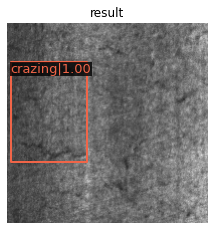

In [8]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot
img = mmcv.imread('data/VOCdevkit/VOC2007/JPEGImages/crazing_210.jpg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)


In [9]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

# Choose to use a config and initialize the detector
config ='configs/cascade_rcnn/cascade_rcnn_r50_fpn_1x_voc07.py'
# Setup a checkpoint file to load
checkpoint = 'tutorial_exps/latest.pth'
# initialize the detector
model = init_detector(config, checkpoint, device='gpu:0')



FileNotFoundError: file "/home/maraden/mmdetection/tugasakhir/Detector RS/configs/cascade_rcnn/cascade_rcnn_r50_fpn_1x_voc07.py" does not exist

In [ ]:
# Use the detector to do inference
img = 'data/VOCdevkit/VOC2007/JPEGImages/pitted_surface_101.jpg'
result = inference_detector(model, img)
# Let's plot the result
show_result_pyplot(model, img, result, score_thr=0.3)